<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

In [3]:
import osmnx as ox

import networkx as nx 

import pandas as pd
from sqlalchemy import func              
from geoalchemy2.shape import to_shape 


from shapely.geometry import Point, Polygon, LineString



import folium

In [4]:
from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 

from grid.lv_grid.routing import build_graph_from_ways, \
get_location_substation_at_pi, subdivide_graph_edges, \
get_mvlv_subst_loc_list, get_cluster_graph_and_nodes, \
add_mv_load_station_to_mvlv_subst_list

from grid.lv_grid.geo import convertCoords

from grid.lv_grid.parameterization import parameterize_by_load_profiles
#from grid.lv_grid.clustering import 

from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, \
get_convex_hull_from_points

#### SET DING0 SETTINGS

In [5]:
# TODO set in config file
ding0_default=False
retain_all=False #  weil sonst graphen außerhalb des polys unverbunden zum graphen beibehalten werden

In [6]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [7]:
%%time

print('ding0_default', ding0_default)
if ding0_default:
    
    lv_stations, lv_grid_districts = nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts)

else:
    
    id_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = nd.import_mv_grid_districts(
        session, ding0_default, mv_grid_districts_no=mv_grid_districts)
    
    #d_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = nd.import_mv_grid_districts(
    #    session, ding0_default, mv_grid_districts_no=mv_grid_districts)

ding0_default False
found
events_venue is not matched in config and will be categorized as leftover
events_venue is not matched in config and will be categorized as leftover
Int64Index([6589915699, 2164602131, 3393042725], dtype='int64')
Begin topologically simplifying the graph...
Simplified graph: 9989 to 5659 nodes, 21188 to 12528 edges
Wall time: 33.6 s


In [8]:
# la aggregated fn
geo_load_area.wkt

'POLYGON ((4276161.08958224 2728507.87661326, 4276168.69107082 2728513.89175017, 4276181.19195395 2728528.53680387, 4276190.62152898 2728545.32468019, 4276192.44063468 2728550.87018552, 4276196.81267006 2728560.77866573, 4276198.54233303 2728563.52208496, 4276215.01158541 2728587.00976708, 4276220.25795443 2728595.34524805, 4276222.48158781 2728599.30202443, 4276230.45450062 2728617.59368736, 4276234.59749725 2728637.11259743, 4276234.7422741 2728657.06582552, 4276230.8829498 2728676.64279892, 4276223.17630415 2728695.04822975, 4276211.93540912 2728711.53442248, 4276197.61691077 2728725.43164797, 4276180.80247858 2728736.17535039, 4276162.17517595 2728743.32908145, 4276157.96766383 2728744.47422231, 4276148.21405167 2728746.60706456, 4276142.01750239 2728747.63783936, 4276139.21366487 2728748.24046868, 4276135.61169576 2728749.56479283, 4276135.52121841 2728749.61900487, 4276135.44243135 2728749.68913114, 4276135.37809599 2728749.77271378, 4276135.33046725 2728749.86682328, 4276135.301

In [9]:
# over unterlottenweiler
geo_load_area.wkt

'POLYGON ((4281997.41869224 2732185.07316504, 4281998.88075016 2732195.14230024, 4281998.01576282 2732213.92516569, 4281993.61512521 2732232.20571892, 4281985.83757831 2732249.32453903, 4281974.9636758 2732264.66411145, 4281961.38566396 2732277.67110312, 4281945.59333238 2732287.87632242, 4281928.15634618 2732294.91164401, 4281909.70369689 2732298.52328794, 4281899.89836158 2732299.48902918, 4281899.80062908 2732299.51867601, 4281899.71055828 2732299.56681985, 4281899.63161057 2732299.63161056, 4281899.56681985 2732299.71055828, 4281899.51867601 2732299.80062907, 4281899.48902918 2732299.89836158, 4281899 2732304.86355813, 4281899 2732400, 4281897.32744326 2732418.12094891, 4281892.36628708 2732435.62960862, 4281884.28416412 2732451.93437859, 4281873.35416141 2732466.48433653, 4281859.9455931 2732478.78785356, 4281844.51152164 2732488.42920582, 4281827.57344925 2732495.08262142, 4281809.70369689 2732498.52328794, 4281799.89836158 2732499.48902918, 4281799.80062908 2732499.51867601, 428

### clustering

In [9]:
from grid.lv_grid.clustering import get_cluster_numbers, apply_AgglomerativeClustering

In [10]:
%%time

n_cluster = get_cluster_numbers(buildings_w_loads_df)

clustering_successfully=False
for i in range(len(simp_graph.nodes)):
    
    # increment n_cluster. n_cluster += 1
    labels = apply_AgglomerativeClustering(simp_graph, n_cluster)
    
    cluster_graph, nodes_w_labels = get_cluster_graph_and_nodes(simp_graph, labels)
    mvlv_subst_list = get_mvlv_subst_loc_list(cluster_graph, nodes_w_labels, street_loads, labels, n_cluster)
    
    if len(mvlv_subst_list) > 0:
        
        print('all clusters are in range')
        
        clustering_successfully=True
        break
        
    else:
        
        n_cluster += 1
        print('n_cluster', n_cluster)
        print('at least one node trespasses dist to substation')
        
if not clustering_successfully:
    
    print('clustering cannot ensure dist from substation to each node <= threshold')

all clusters are in range
Wall time: 6.01 s


In [11]:
n_cluster

124

In [12]:
%%time


# get loadds on mv level
#mv_lv_level_threshold = get_config_osm('mv_lv_threshold_capacity')
# TODO weg mit den 40 wg testing
mv_lv_level_threshold = 1000

loads_mv_df = buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= mv_lv_level_threshold]

#assign cluster id to loads on mv level
mv_cluster_ids = list(range(n_cluster, n_cluster + len(loads_mv_df)))
loads_mv_df['cluster'] = mv_cluster_ids


# map cluster to buildings of lv level
buildings_w_loads_df = buildings_w_loads_df[~buildings_w_loads_df.index.isin(loads_mv_df.index.tolist())]
buildings_w_loads_df['cluster'] = buildings_w_loads_df.nn.map(nodes_w_labels.cluster)


# concat lv and mv level after assignment of cluster ids
buildings_w_loads_df = pd.concat([buildings_w_loads_df, loads_mv_df])

mvlv_subst_list = add_mv_load_station_to_mvlv_subst_list(loads_mv_df, mvlv_subst_list, nodes_w_labels)

Wall time: 1.23 s


In [13]:
len(mvlv_subst_list)

177

In [14]:
len(loads_mv_df)

53

In [15]:
loads_mv_df.category.value_counts()

industrial    40
school         8
cafe           3
retail         1
fast_food      1
Name: category, dtype: int64

In [16]:
import geopandas
gdf = geopandas.GeoDataFrame(buildings_w_loads_df, geometry=buildings_w_loads_df.geometry)

Wall time: 4.87 s


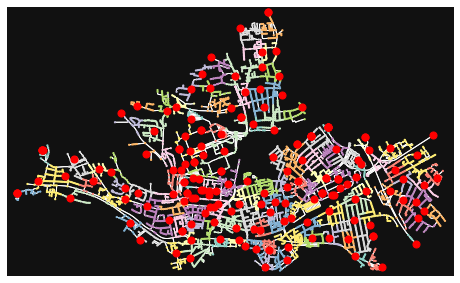

In [19]:
%%time

X = []    # collect nodes
for node in simp_graph.nodes:
    X.append((simp_graph.nodes[node]['x'],simp_graph.nodes[node]['y']))

xy = list(zip(*X))
x = xy[0]
y = xy[1]

nc = ox.plot.get_node_colors_by_attr(cluster_graph, attr='cluster', cmap='Set3')
fig, ax = ox.plot_graph(cluster_graph, node_color=nc, node_size=5, edge_color='w', edge_linewidth=1, show=False, close=False)


#gdf.plot(ax=ax, edgecolor=(1,0,0,1), facecolor=(1,0,0,.3))


#for i, l in enumerate(labels):
    
#    ax.text(x[i], y[i], s=l, c='white')
    
for mvlv_subst_loc in mvlv_subst_list:
    
    ax.scatter(mvlv_subst_loc['x'],mvlv_subst_loc['y'],s=50,c='red')

In [34]:
osmids = []

for mvstation in mvlv_subst_list:
    
    osmids.append(mvstation.get('osmid'))

In [35]:
# 345557226
osmids[0]

345557226

In [36]:
%%time

xy_list = osmids
dist = lambda p1, p2: nx.shortest_path_length(cluster_graph, p1, p2, weight='length')
dm = [[dist(p1, p2) for p2 in xy_list] for p1 in xy_list]


Wall time: 11min 23s


In [38]:
pd.DataFrame(dm)

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,3057.750803,1867.817065,2879.535268,5519.716755,4466.436230,3517.577204,3460.927663,5185.781281,1128.799001,...,5519.716755,6241.623681,1867.817065,3837.850663,1959.484508,1785.785774,2062.740498,2062.740498,2062.740498,2062.740498
1,3057.750803,0.000000,2332.617450,4402.326566,3292.344555,2457.102801,1462.806224,1817.297574,3176.447852,2175.362754,...,3292.344555,4232.290252,2332.617450,1349.710127,1602.622296,1344.659308,1845.619863,1845.619863,1845.619863,1845.619863
2,1867.817065,2332.617450,0.000000,3212.392829,4653.466449,3600.185924,2651.326899,2735.794310,4319.530976,985.429016,...,4653.466449,5375.373375,0.000000,2971.600358,1237.317746,1063.619012,942.935048,942.935048,942.935048,942.935048
3,2879.535268,4402.326566,3212.392829,0.000000,6864.292518,5811.011993,4862.152968,4805.503426,6530.357045,2473.374764,...,6864.292518,7586.199444,3212.392829,5182.426427,3304.060271,3130.361537,3407.316261,3407.316261,3407.316261,3407.316261
4,5519.716755,3292.344555,4653.466449,6864.292518,0.000000,3589.734437,2453.249734,4696.739531,4320.781434,4637.328705,...,0.000000,5376.623834,4653.466449,2373.472621,4170.048342,3912.085353,4140.184505,4140.184505,4140.184505,4140.184505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1785.785774,1344.659308,1063.619012,3130.361537,3912.085353,2858.804829,1909.945803,1747.836168,3578.149880,903.397725,...,3912.085353,4633.992280,1063.619012,2230.219262,257.962988,0.000000,998.344294,998.344294,998.344294,998.344294
173,2062.740498,1845.619863,942.935048,3407.316261,4140.184505,2965.632297,2016.773271,2321.865757,3684.977348,1180.352449,...,4140.184505,4740.819748,942.935048,2458.318414,1172.043028,998.344294,0.000000,0.000000,0.000000,0.000000
174,2062.740498,1845.619863,942.935048,3407.316261,4140.184505,2965.632297,2016.773271,2321.865757,3684.977348,1180.352449,...,4140.184505,4740.819748,942.935048,2458.318414,1172.043028,998.344294,0.000000,0.000000,0.000000,0.000000
175,2062.740498,1845.619863,942.935048,3407.316261,4140.184505,2965.632297,2016.773271,2321.865757,3684.977348,1180.352449,...,4140.184505,4740.819748,942.935048,2458.318414,1172.043028,998.344294,0.000000,0.000000,0.000000,0.000000


In [24]:
len(buildings_w_loads_df), len(buildings_w_loads_df.loc[buildings_w_loads_df.capacity < 5500]), len(buildings_w_loads_df.loc[buildings_w_loads_df.capacity > 5500])

(12772, 12765, 7)

In [21]:
buildings_w_loads_df.loc[buildings_w_loads_df.capacity < 5500].sort_values('capacity', ascending=False)


,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords,cluster
100342458,school,85415.0000,"POLYGON ((4283083.273 2726885.506, 4283093.346...",POINT (4283152.28671644 2726804.041308777),Gemeinschaftsschule Schreienesch,1.0,1.0,NaN,NaN,4283152.286716,2726804.041309,5312.813000,188960660,33.307790,POINT (4283166.253758295 2726773.803408181),153
89309362,industrial,31325.1000,"POLYGON ((4280803.303 2727739.533, 4280813.679...",POINT (4280873.017927655 2727677.585071916),None,1.0,1.0,NaN,NaN,4280873.017928,2727677.585072,5152.978950,663643865801,54.267409,POINT (4280922.445206905 2727699.988101861),141
89371949,industrial,25327.8000,"POLYGON ((4277792.778 2728092.748, 4278005.869...",POINT (4277933.24010508 2727988.637153339),None,1.0,1.0,NaN,NaN,4277933.240105,2727988.637153,4166.423100,94779988,1027.546386,POINT (4278705.300408176 2727310.570442497),150
89309361,industrial,22860.4000,"POLYGON ((4280706.128 2727735.292, 4280735.953...",POINT (4280770.70413539 2727669.99442703),None,1.0,1.0,NaN,NaN,4280770.704135,2727669.994427,3760.535800,455640350805,38.581720,POINT (4280808.172740509 2727679.195119872),140
89309363,industrial,20814.6000,"POLYGON ((4280921.384 2727752.982, 4280940.830...",POINT (4281042.657579781 2727764.311829919),None,1.0,1.0,NaN,NaN,4281042.65758,2727764.31183,3424.001700,1269518757501,20.931968,POINT (4281032.050311864 2727782.357138211),142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126996667,place_of_worship,95.1084,"POLYGON ((4283382.189 2730773.161, 4283382.368...",POINT (4283385.915033999 2730770.307868303),None,1.0,1.0,NaN,NaN,4283385.915034,2730770.307868,0.009511,177585688,1948.572137,POINT (4281843.296583772 2729579.819863414),54
125963551,place_of_worship,92.2192,"POLYGON ((4282022.571 2728745.593, 4282025.896...",POINT (4282028.307829497 2728746.186054747),St. Blasius-Kapelle,1.0,1.0,NaN,NaN,4282028.307829,2728746.186055,0.009222,284934381901,17.575357,POINT (4282012.447704466 2728753.759006374),70
290570089,place_of_worship,88.1108,"POLYGON ((4278870.505 2728933.648, 4278874.051...",POINT (4278874.894615591 2728932.759306513),Gedenkkapelle,1.0,1.0,NaN,NaN,4278874.894616,2728932.759307,0.008811,249113245,1046.276453,POINT (4279086.343050268 2727908.072049021),4
675853367,place_of_worship,61.7612,"POLYGON ((4276788.173 2728760.272, 4276789.214...",POINT (4276791.281387898 2728760.098863105),None,1.0,1.0,NaN,NaN,4276791.281388,2728760.098863,0.006176,94779988,2400.958444,POINT (4278705.300408176 2727310.570442497),49


In [13]:
from shapely.geometry import MultiPoint, Point, shape
from grid.lv_grid.geo import get_points_in_load_area, get_convex_hull_from_points

In [14]:
# init empty stations_df
lv_stations = pd.DataFrame(columns=['la_id', 'geom'])
lv_stations.index.name = 'mvlv_subst_id'

In [29]:
# add stations for cluster load centers
last_row_ix = len(lv_stations)
for mvlv_subst_loc in mvlv_subst_list:
    
    cluster_id = mvlv_subst_loc.get('cluster')
    # TODO: check lon lat instead x, y?
    lv_stations.loc[last_row_ix+cluster_id] = [id_db, Point(mvlv_subst_loc.get('x'),mvlv_subst_loc.get('y'))]


C:\Users\Robert\anaconda3\envs\ox\lib\site-packages\pandas\core\dtypes\cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [30]:
%%time

ch_polys = []

for cluster_i in range(len(mvlv_subst_list)):

    # get convex hull per cluster
    cluster_geo_list = buildings_w_loads_df.loc[buildings_w_loads_df.cluster==cluster_i].geometry.tolist()

    points = get_points_in_load_area(cluster_geo_list)

    polygon = get_convex_hull_from_points(points)
    
    ch_polys.append(polygon)

Wall time: 66.9 ms


In [31]:
lv_stations

,la_id,geom
mvlv_subst_id,,
0,5588,POINT (4282465.613186001 2732307.092790205)
1,5588,POINT (4282038.495855372 2732459.481623211)
2,5588,POINT (4282171.955938512 2732383.531130372)
3,5588,POINT (4282081.426960234 2732230.693110299)
4,5588,POINT (4282194.306077464 2732456.63506963)


In [11]:
lv_stations.head(2)

,la_id,geom
mvlv_subst_id,,
2873,2520,POINT(9.49063792246541 47.7452397283099)
3053,2728,POINT(9.49342672911522 47.7327193529698)


In [ ]:
# init empty stations_df
lv_grid_districts = pd.DataFrame(columns=['la_id', 'geom'])
lv_grid_districts.index.name = 'mvlv_subst_id'

In [12]:
lv_grid_districts.head(2)

,la_id,population,peak_load_residential,peak_load_retail,peak_load_industrial,peak_load_agricultural,peak_load,geom,sector_count_residential,sector_count_retail,sector_count_industrial,sector_count_agricultural,sector_consumption_residential,sector_consumption_retail,sector_consumption_industrial,sector_consumption_agricultural
mvlv_subst_id,,,,,,,,,,,,,,,,
419093,5372,10.0,3.493570,0.0,0.0,99.525989,103.019559,MULTIPOLYGON(((9.44476423426424 47.69930354485...,0.0,0.0,0.0,2.0,16346.482102,0.0,0.0,414070.515734
420154,4830,3.0,1.048071,0.0,0.0,0.000000,1.048071,MULTIPOLYGON(((9.49954883830014 47.68339565373...,1.0,0.0,0.0,0.0,4903.944631,0.0,0.0,0.000000


In [22]:
# update load areal peak loads in the end 
# due to residentials at feeder needs to be updated
buildings_w_loads_df.capacity.sum()

250.2653091931388

In [ ]:
# additionally for object
# lv_grid as lv_grid-Obect

# df
la_id
population
peak_load_residential
peak_load_retail
peak_load_industrial
peak_load_agricultural
peak_load
geom
sector_count_residential
sector_count_retail
sector_count_industrial
sector_count_agricultural
sector_consumption_residential
sector_consumption_retail
sector_consumption_industrial
sector_consumption_agricultural

In [15]:
# district e.g.
'id_db': 4563,
'geo_data': <shapely.geometry.multipolygon.MultiPolygon at 0x17ffc430160>,
'lv_load_area': lv_load_area_4544,
'lv_grid': lv_grid_4563,
'population': 80,
'peak_load_residential': 27.9485612387548,
'peak_load_retail': 0.0,
'peak_load_industrial': 0.0,
'peak_load_agricultural': 0.0,
'peak_load': 27.9485612387548,
'sector_count_residential': 1,
'sector_count_retail': 0,
'sector_count_industrial': 0,
'sector_count_agricultural': 0,
'sector_consumption_residential': 130771.856816184,
'sector_consumption_retail': 0.0,
'sector_consumption_industrial': 0.0,
'sector_consumption_agricultural': 0.0

,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords
443340114,restaurant,732.547,"POLYGON ((9.483392699999998 47.70459640000707,...",POINT (9.48352605 47.70469195000704),Sportplatz-Restaurant,1.0,1.0,301431136.0,0101000020e6100000c3d3861e8cf72240da9a83ea30da...,9.483526,47.704692,67.035376,443338172,29.025206,POINT (9.483255199999999 47.70450509625661)


In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

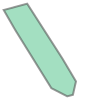

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

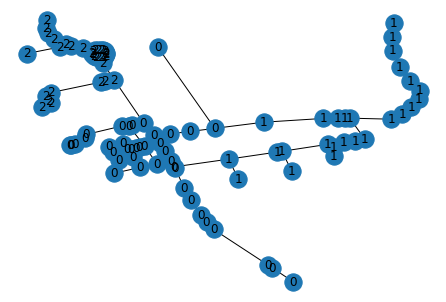

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

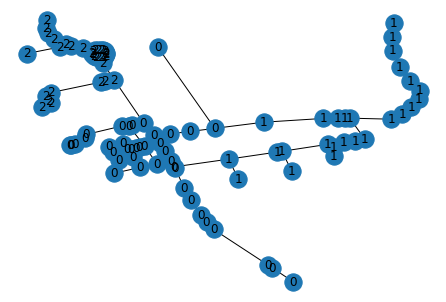

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)